In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor
from utils.UL_uncert import UL_uncert

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

In [3]:
TMIN = 53217.0
TMAX = 56599.0
tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

In [8]:
runroot = '/home/kpislo/nano9_bwm_kislo/allsky/'

In [9]:
ephem = 'DE436'
bayesephem = True
BE = '_BE' if bayesephem else ''
chunk = 'all'
ii_t = None  # 0-40

if ii_t:
    tmin, cent, tmax = tlim[ii_t]
    chunk = '{:.2f}'.format(cent)

rundir = runroot+'{0:s}{1:s}/{2:s}/'.format(ephem, BE, chunk)

In [10]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

In [11]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [12]:
burnfrac = 0.10
thin = 20

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

N = 40910, corL = 68.8871216871


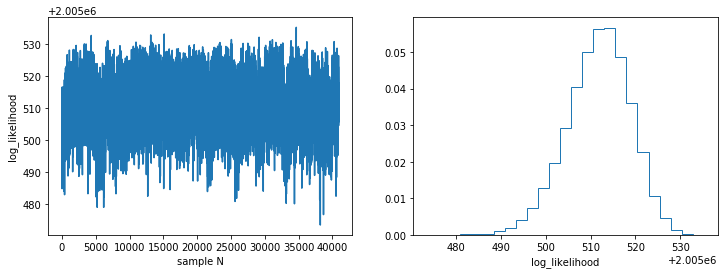

In [13]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(chain_L)
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(chain_L, bins=25, density=True, histtype='step')
ax2.set_xlabel('log_likelihood');

## trace plots

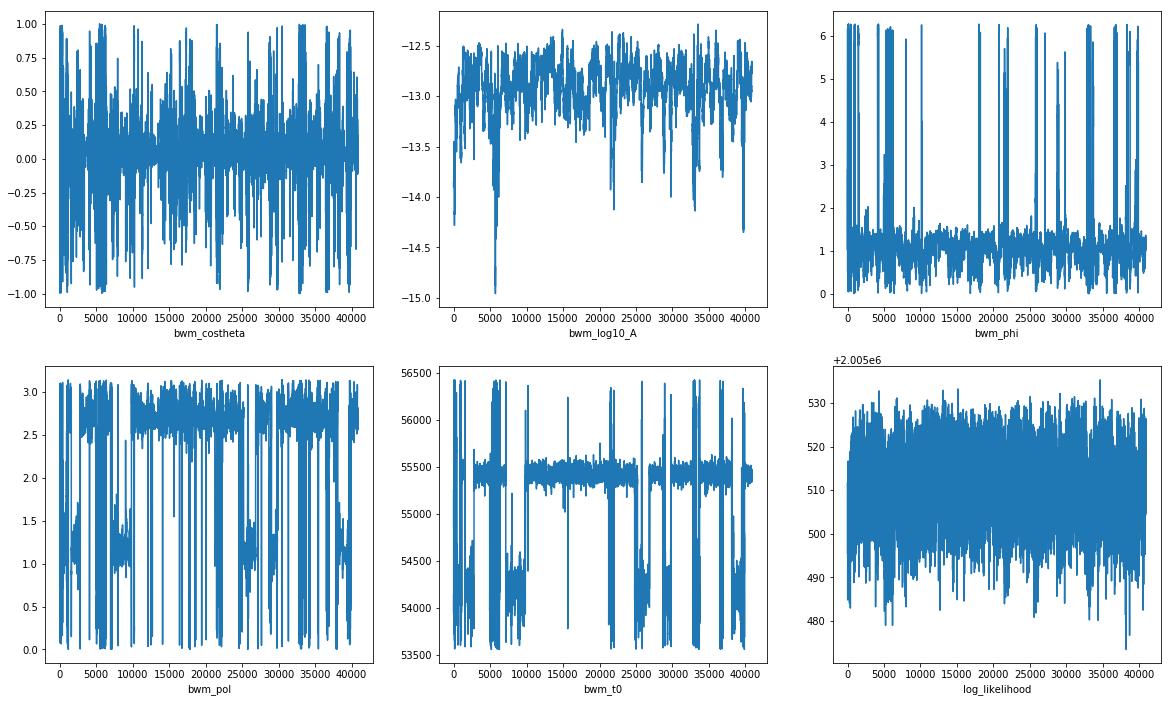

In [14]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].plot(chain_bwm[:,pp])
    ax[pp].set_xlabel(par)

ax.append(fig.add_subplot(2,3,6))
ax[5].plot(chain[:,-4])
ax[5].set_xlabel('log_likelihood');

## Corner and Histograms

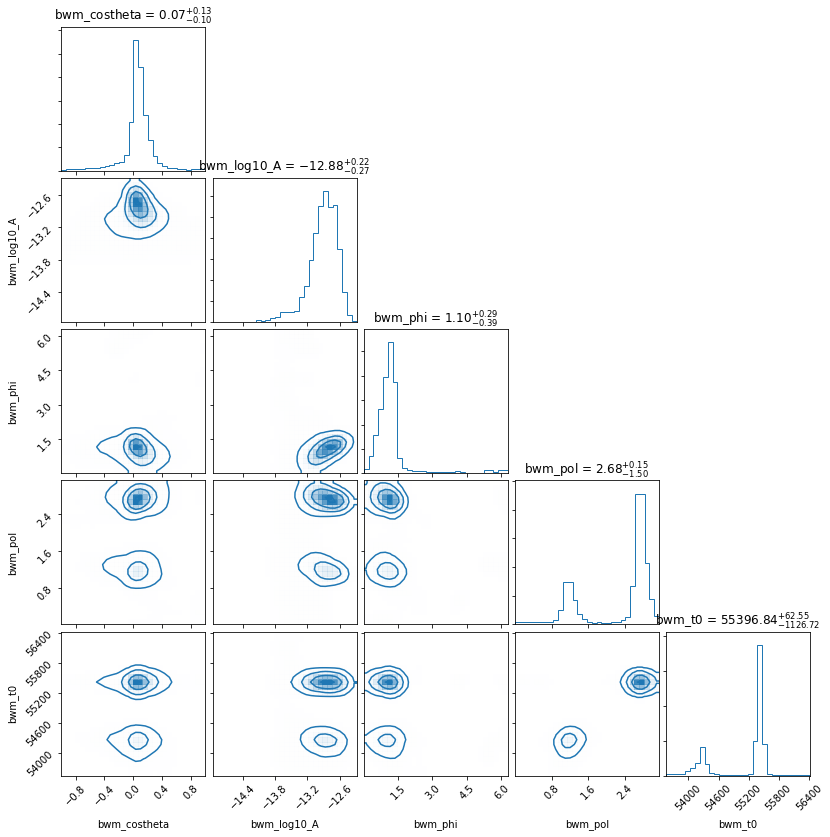

In [15]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':1.0,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

Text(0.5,0,u'log_likelihood')

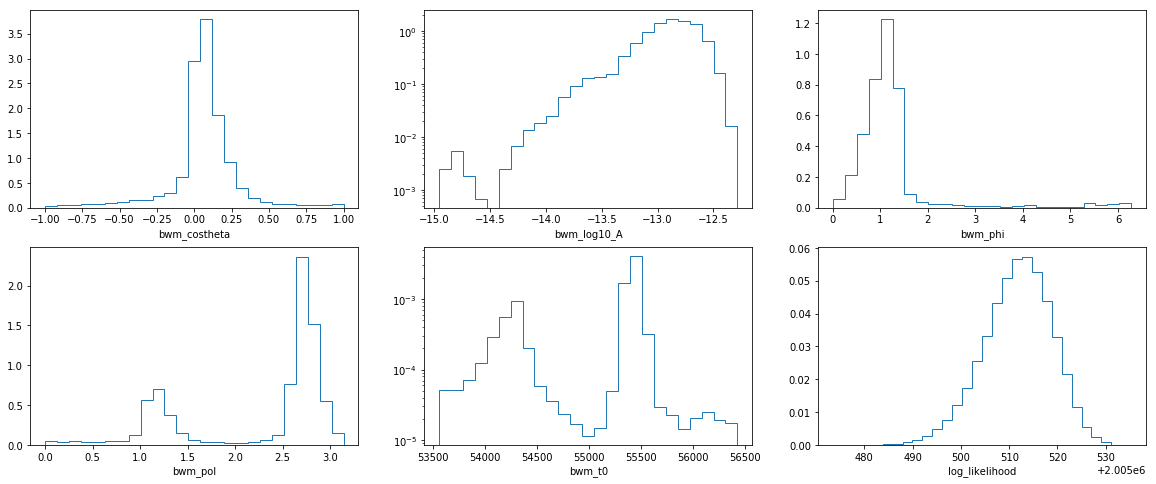

In [16]:
ax = []
fig = plt.figure(figsize=(20,8))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain_bwm[:,pp], bins=25, density=True, histtype='step') #, label='')
    ax[pp].set_xlabel(par)

#ax[0].legend(loc='upper left')
ax[idx_A].set_yscale('log')
ax[idx_t0].set_yscale('log')

ax.append(fig.add_subplot(2,3,6))
ax[5].hist(chain[:,-4], bins=30, density=True, histtype='step')
ax[5].set_xlabel('log_likelihood')

(53217.0, 56599.0)

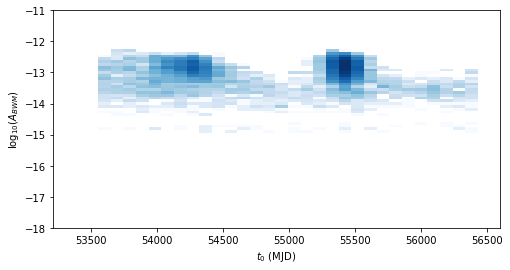

In [17]:
lognorm = LogNorm()

hist_kwargs = {'bins':30,
               'normed':True,
               'cmap':'Blues',
               #'vmin':1.0e5,
               #'vmax':1.0e10,
               'norm':lognorm,
                }

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

t_ch = chain_bwm[:,idx_t0]
logA_ch = chain_bwm[:,idx_A]
A_ch = 10**logA_ch
    
ax.hist2d(t_ch, logA_ch, **hist_kwargs)

if ii_t:
    ax.axvline(x=tmin, color='k', linestyle=':')
    ax.axvline(x=tmax, color='k', linestyle=':')

ax.set_xlabel(r'$t_0$ (MJD)')
ax.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax.set_ylim([-18,-11])
ax.set_xlim([TMIN, TMAX])
#ax.set_title('{:.1f} yr timeslice (w/ dropout)'.format(slice_yr))

/home/pbaker/.local/opt/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


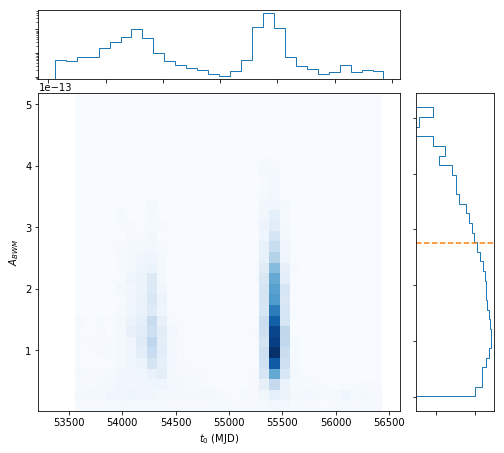

In [18]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter

UL, dUL = UL_uncert(A_ch, p=0.95)

# Define size of figure
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(10, 12)

# Define the positions of the subplots.
ax0 = plt.subplot(gs[6:10, 5:9])
axx = plt.subplot(gs[5:6, 5:9])
axy = plt.subplot(gs[6:10, 9:10])


hist_kwargs = {'bins':30,
               'normed':True,
               'cmap':'Blues',
              }
ax0.hist2d(t_ch, A_ch, **hist_kwargs)
ax0.set_xlabel(r'$t_0$ (MJD)')
ax0.set_ylabel(r'$A_{BWM}$')
ax0.set_xlim([TMIN, TMAX])
#ax0.set_ylim([0, 0.13e-12])

axx.hist(t_ch, 30, normed=True, histtype='step', color='C0')
axx.set_yscale('log')
axy.hist(A_ch, 30, normed=True, histtype='step', color='C0', orientation='horizontal')
axy.axhline(y=UL, color='C1', linestyle='--')
axy.set_xscale('log')
               
# Remove tick labels
nullfmt = NullFormatter()
axx.xaxis.set_major_formatter(nullfmt)
axx.yaxis.set_major_formatter(nullfmt)
axy.xaxis.set_major_formatter(nullfmt)
axy.yaxis.set_major_formatter(nullfmt)

# UL v. t_0

In [20]:
burnfrac = 0.15
thin = 20

ephems = ['DE421', 'DE430', 'DE436']
bayeseph_flags = [True, False]

#ephems = ['DE421']
#bayeseph_flags = [False]
#figs = []

ULs = {}
dULs = {}

for ephem in ephems:
    for bayesephem in bayeseph_flags:
        BE = '_BE' if bayesephem else ''
        key = ephem+BE
        print(key)
        ULs[key] = []
        dULs[key] = []

        for ts in tlim:
            tmin, cent, tmax = ts
            chunk = '{:.2f}'.format(cent)
            rundir = runroot + '{0:s}/{1:s}/'.format(key, chunk)
            chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                                    sep='\t', dtype=float, header=None).values
            burn = int(burnfrac * len(chain_raw))
            chain = chain_raw[burn::thin]
            chain_bwm = chain[:,idx_bwm]  # no ephem model
            chain_L = chain[:,-4]

            corL = acor(chain_L)[0]
            corA = acor(chain_bwm[:,idx_A])[0]
            N = len(chain_bwm)
            print("{:.2f}: N = {:d}, corL = {:.2f}, corA = {:.2f}".format(cent, N, corL, corA))
    
            this_UL, this_dUL = UL_uncert(10**chain_bwm[:,idx_A], p=0.95)
            ULs[key].append(this_UL)
            dULs[key].append(this_dUL)
            
            #figs.append(hist_plot(chain_bwm, par_bwm, cols=5, wid_per_col=2.5))

print('DONE!')

DE421_BE
53301.55: N = 32963, corL = 9.47, corA = 6.95
53386.10: N = 32929, corL = 7.90, corA = 34.72
53470.65: N = 30184, corL = 10.48, corA = 61.52
53555.20: N = 32062, corL = 7.81, corA = 66.12
53639.75: N = 32802, corL = 7.30, corA = 67.03
53724.30: N = 14782, corL = 10.95, corA = 139.80
53808.85: N = 32186, corL = 22.64, corA = 196.86
53893.40: N = 34723, corL = 37.76, corA = 222.21
53977.95: N = 32993, corL = 5.64, corA = 78.06
54062.50: N = 15475, corL = 31.15, corA = 170.44
54147.05: N = 30770, corL = 43.69, corA = 30.99
54231.60: N = 31174, corL = 46.59, corA = 272.83
54316.15: N = 33189, corL = 21.24, corA = 93.37
54400.70: N = 33788, corL = 28.30, corA = 183.00
54485.25: N = 32934, corL = 17.15, corA = 261.97
54569.80: N = 33427, corL = 15.05, corA = 87.26
54654.35: N = 30872, corL = 8.85, corA = 133.20
54738.90: N = 31926, corL = 7.41, corA = 144.37
54823.45: N = 33886, corL = 10.41, corA = 168.21
54908.00: N = 31221, corL = 6.47, corA = 121.82
54992.55: N = 32007, corL = 5

54654.35: N = 26486, corL = 8.29, corA = 111.83
54738.90: N = 27128, corL = 10.38, corA = 90.64
54823.45: N = 31208, corL = 11.39, corA = 140.29
54908.00: N = 12011, corL = 7.26, corA = 45.19
54992.55: N = 30078, corL = 10.15, corA = 39.68
55077.10: N = 31578, corL = 11.07, corA = 149.50
55161.65: N = 31395, corL = 17.51, corA = 211.33
55246.20: N = 29181, corL = 34.42, corA = 184.53
55330.75: N = 31557, corL = 16.77, corA = 228.85
55415.30: N = 10098, corL = 16.73, corA = 51.35
55499.85: N = 11284, corL = 10.56, corA = 67.42
55584.40: N = 28569, corL = 53.27, corA = 132.02
55668.95: N = 29963, corL = 12.70, corA = 131.94
55753.50: N = 11790, corL = 6.63, corA = 153.27
55838.05: N = 11820, corL = 6.79, corA = 72.18
55922.60: N = 32657, corL = 5.86, corA = 127.17
56007.15: N = 26750, corL = 11.10, corA = 134.67
56091.70: N = 28123, corL = 10.63, corA = 72.86
56176.25: N = 31965, corL = 7.05, corA = 107.24
56260.80: N = 10795, corL = 9.26, corA = 54.73
56345.35: N = 29865, corL = 7.87, c

In [ ]:
# save per chunk hists
outdir = "hists_"+key
!mkdir -p $outdir

for ii,fig in enumerate(figs):
    fig.savefig("hists_"+key+"/hist_{:02d}.png".format(ii))
    plt.close(fig)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.7,
        'ytick.major.width':0.7,
        'xtick.minor.width':0.7,
        'ytick.minor.width':0.7,
        'lines.markeredgewidth':1.2,
        'axes.linewidth':1.375,
        'legend.fontsize': 7,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'savefig.dpi':200,
        'path.simplify':True,
        #'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble':'\\usepackage{amsmath}',
        'text.usetex':True,
         }

plt.rcParams.update(params)

In [26]:
from astropy.time import Time

Ts = np.array(tlim)[:,1]

Ts = Time(Ts, format='mjd').decimalyear

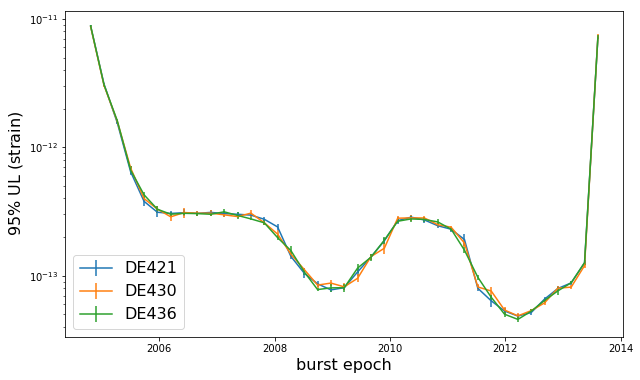

In [24]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.errorbar(Ts, ULs['DE421'], yerr=dULs['DE421'], color='C0', label='DE421')
ax.errorbar(Ts, ULs['DE430'], yerr=dULs['DE430'], color='C1', label='DE430')
ax.errorbar(Ts, ULs['DE436'], yerr=dULs['DE436'], color='C2', label='DE436')

#ax.errorbar(Ts, ULs['DE421_BE'], yerr=dULs['DE421_BE'], color='C0', label='DE421')
#ax.errorbar(Ts, ULs['DE430_BE'], yerr=dULs['DE430_BE'], color='C1', label='DE430')
#ax.errorbar(Ts, ULs['DE436_BE'], yerr=dULs['DE436_BE'], color='C1', label='DE436')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

fig.savefig('/home/pbaker/11yr_ULvt.pdf')
plt.show()

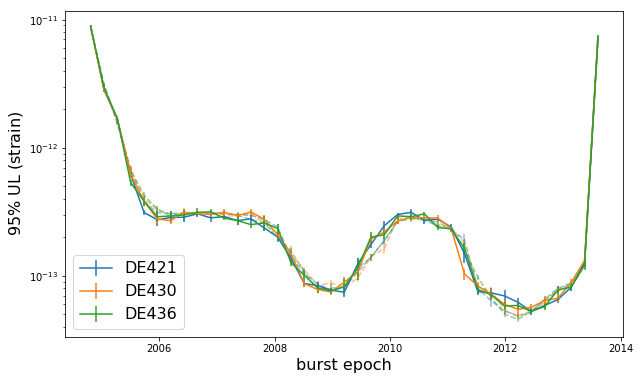

In [25]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.errorbar(Ts, ULs['DE421'], yerr=dULs['DE421'], color='C0', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs['DE430'], yerr=dULs['DE430'], color='C1', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs['DE436'], yerr=dULs['DE436'], color='C2', alpha=0.5, ls='--')

ax.errorbar(Ts, ULs['DE421_BE'], yerr=dULs['DE421_BE'], color='C0', label='DE421')
ax.errorbar(Ts, ULs['DE430_BE'], yerr=dULs['DE430_BE'], color='C1', label='DE430')
ax.errorbar(Ts, ULs['DE436_BE'], yerr=dULs['DE436_BE'], color='C2', label='DE436')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

fig.savefig('/home/pbaker/11yr_ULvt_BE.pdf')
plt.show()

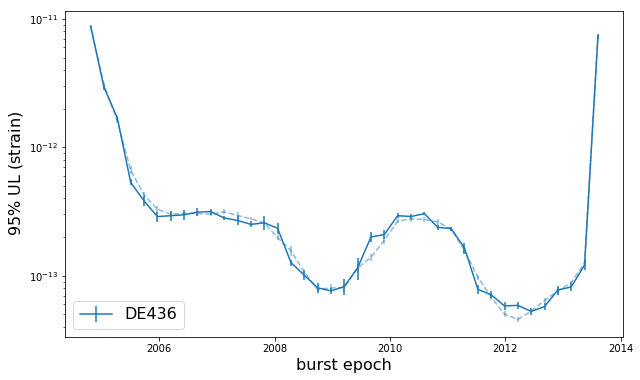

In [27]:
plt.close('all')

ephem = 'DE436'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.errorbar(Ts, ULs[ephem], yerr=dULs[ephem], color='C0', alpha=0.5, ls='--')
ax.errorbar(Ts, ULs[ephem+'_BE'], yerr=dULs[ephem+'_BE'], color='C0', label=ephem)

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

#fig.savefig('/home/pbaker/11yr_ULvt_compare.pdf')
plt.show()

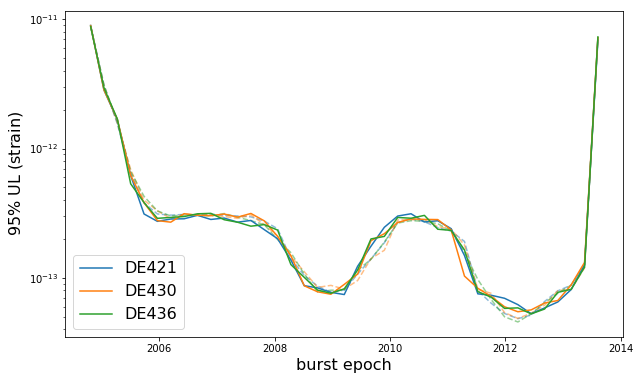

In [28]:
plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(Ts, ULs['DE421'], color='C0', alpha=0.5, ls='--')
ax.plot(Ts, ULs['DE430'], color='C1', alpha=0.5, ls='--')
ax.plot(Ts, ULs['DE436'], color='C2', alpha=0.5, ls='--')

ax.plot(Ts, ULs['DE421_BE'], color='C0', label='DE421')
ax.plot(Ts, ULs['DE430_BE'], color='C1', label='DE430')
ax.plot(Ts, ULs['DE436_BE'], color='C2', label='DE436')

ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

#fig.savefig('/home/pbaker/11yr_ULvt_BE.pdf')
plt.show()

# Rate Upper Limit

In [29]:
from scipy.integrate import simps

_GMsun = 1.32712440018e20  # m^3/s^2
_c = 299792458 # m/s
_Rsun = _GMsun / _c**2 # meters
_pc = 3.0857e16 # meters

M = 1e10 * _Rsun / (1e9*_pc) # Gpc
Erad = 0.07*M  # energy radiated

# h = 69/(8*24) Erad/r

hUL = np.array(ULs['DE436_BE'])

r_sens = 69/(8*24) * Erad / hUL
V_sens = 4/3*np.pi * r_sens**3

rateUL = simps(y=V_sens, x=Ts) # /Gpc^3 /yr

In [30]:
69/(8*24) * 0.07 *_Rsun

37.14634861848667

In [31]:
rateUL

0.070241592618583704

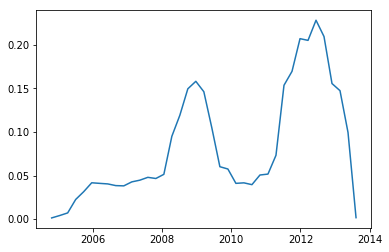

In [32]:
plt.plot(Ts, r_sens)

In [34]:
dT = np.mean(np.diff(Ts))
hsort = np.sort(hUL)
Ns = np.arange(len(hsort))+1

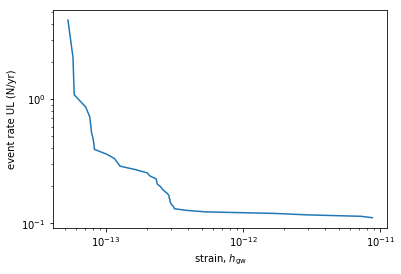

In [35]:
plt.plot(hsort, 1/(Ns*dT))
plt.xlabel('strain, $h_\mathrm{gw}$')
plt.ylabel('event rate UL (N/yr)')
plt.xscale('log')
plt.yscale('log')

In [41]:
cols = [k for k in ULs.keys()]
ULvt = np.vstack([u for u in ULs.values()])
dULvt = np.vstack([u for u in dULs.values()])

np.savetxt('./ULvT/9yr_cols.dat', cols, fmt=b'%s')
np.savetxt('./ULvT/9yr_UL.dat', ULvt)
np.savetxt('./ULvT/9yr_dUL.dat', dULvt)
np.savetxt('./ULvT/9yr_Ts.dat', Ts)

In [ ]:
Tobs = TMAX-TMIN

0.1*Tobs / 365.25

In [ ]:
UL